# Image Clustering Project

## Introduction

In this project, we will perform image clustering using a set of images stored in a directory.

The goal is to group similar images together using unsupervised learning techniques.

We will use the MobileNet model for feature extraction, apply KMeans clustering to group images, and visualize the clustering results.

This notebook demonstrates the end-to-end process of loading images, extracting features, clustering, and visualizing results.



# Loading Images

## Explanation:

This code snippet defines a function to load and preprocess images from a specified folder.

Images are resized to a consistent size (64x64) and stored in a list.

The filenames are also stored for later use.


In [49]:
import os
import cv2
import numpy as np

def load_images_from_folder(folder_path, size=(64, 64)):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, size)
            images.append(img)
            filenames.append(filename)
    return np.array(images), filenames

image_folder = 'google'
images, filenames = load_images_from_folder(image_folder)

## Feature Extraction using MobileNet

**Explanation:**

This snippet sets up the MobileNet model for feature extraction by removing the top layers.

The `extract_features` function preprocesses images and extracts features using the MobileNet model.

Features are flattened and returned as a NumPy array.


In [34]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.models import Model

# Load MobileNet model and remove the top layers
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)


C:\Users\tamat\AppData\Local\Temp\ipykernel_31660\996794340.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


In [35]:
def extract_features(images, batch_size=32):
    features = []
    num_batches = len(images) // batch_size + 1
    for i in range(num_batches):
        batch = images[i * batch_size:(i + 1) * batch_size]
        batch = np.array(batch)
        batch = preprocess_input(batch)
        batch_features = model.predict(batch)
        for feature in batch_features:
            features.append(feature.flatten())
    return np.array(features)


In [36]:
def load_images_from_folder(folder_path, size=(128, 128)):  # Increase size for better quality if needed
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, size)
            images.append(img)
            filenames.append(filename)
    return np.array(images), filenames


# Feature Extraction using MobileNet

## Explanation:

This snippet sets up the MobileNet model for feature extraction by removing the top layers.

The `extract_features` function preprocesses images and extracts features using the MobileNet model.

Features are flattened and returned as a NumPy array.

In [37]:
from joblib import Parallel, delayed

def extract_feature(img):
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    feature = model.predict(img)
    return feature.flatten()

def extract_features_parallel(images, n_jobs=-1):
    features = Parallel(n_jobs=n_jobs)(delayed(extract_feature)(img) for img in images)
    return np.array(features)


In [38]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import cv2
import os

# Load MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

# Function to load and preprocess images
def load_images_from_folder(folder_path, size=(64, 64)):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, size)
            img = preprocess_input(img)  # Preprocess for MobileNet
            images.append(img)
            filenames.append(filename)
    return np.array(images), filenames

# Load images and extract features
image_folder = 'google'
images, filenames = load_images_from_folder(image_folder)
features = model.predict(images)  # Extract features

# Save features to file
import joblib
joblib.dump(features, 'features.pkl')


C:\Users\tamat\AppData\Local\Temp\ipykernel_31660\4261475982.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 203s 129ms/step


['features.pkl']

In [39]:
import joblib
joblib.dump(features, 'features.pkl')


['features.pkl']

In [40]:
features = joblib.load('features.pkl')


In [41]:
import joblib

# Load features
features = joblib.load('features.pkl')


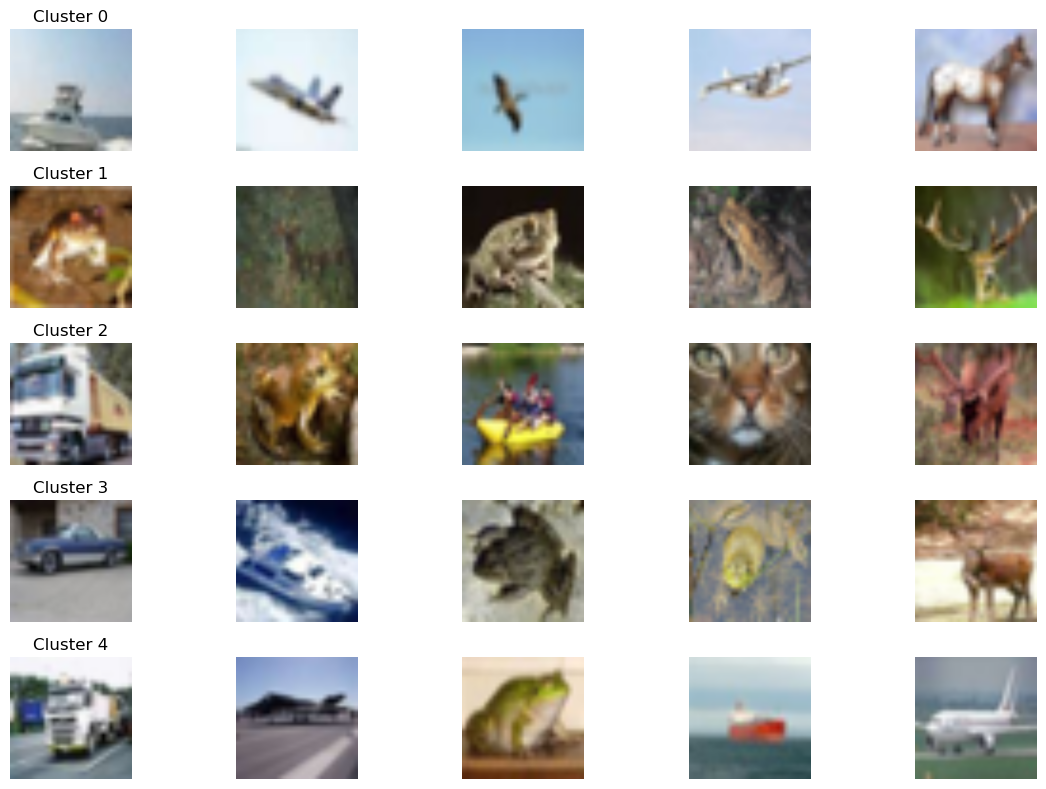

In [42]:
import os
import cv2
import numpy as np
import joblib
from sklearn.cluster import KMeans
from collections import defaultdict
import matplotlib.pyplot as plt

# Load and preprocess images
def load_images_from_folder(folder_path, size=(64, 64)):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, size)
            images.append(img)
            filenames.append(filename)
    return np.array(images), filenames

def flatten_images(images):
    num_images = images.shape[0]
    height, width, channels = images.shape[1:]
    flattened_images = images.reshape(num_images, -1)  # Flatten each image
    return flattened_images

def cluster_images(features, num_clusters=5):
    kmeans = KMeans(n_clusters=num_clusters, n_init=10)
    kmeans.fit(features)
    return kmeans.labels_

def organize_by_cluster(filenames, labels):
    clusters = defaultdict(list)
    for filename, label in zip(filenames, labels):
        clusters[label].append(filename)
    return dict(clusters)

def plot_clusters(cluster_data, image_directory):
    num_clusters = len(cluster_data)
    plt.figure(figsize=(12, 8))
    
    for i in range(num_clusters):
        cluster_images = cluster_data.get(i, [])
        plt.subplot(num_clusters, 5, i * 5 + 1)
        plt.title(f'Cluster {i}')
        for j, image_file in enumerate(cluster_images[:5]):  # Display up to 5 images per cluster
            image_path = os.path.join(image_directory, image_file)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (224, 224))
                plt.subplot(num_clusters, 5, i * 5 + j + 1)
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Main
image_folder = 'google'
images, filenames = load_images_from_folder(image_folder)
features = flatten_images(images)
num_clusters = 5
labels = cluster_images(features, num_clusters)
clusters = organize_by_cluster(filenames, labels)

# Save the cluster results
joblib.dump(clusters, 'clusters.pkl')

# Visualize the clusters
plot_clusters(clusters, image_folder)


In [43]:
from sklearn.metrics import silhouette_score

def evaluate_clustering(features, labels):
    score = silhouette_score(features, labels)
    print(f'Silhouette Score: {score}')

evaluate_clustering(features, labels)


Silhouette Score: 0.08071608183329715


In [44]:
import joblib

# Save features for later use
joblib.dump(features, 'features.pkl')


['features.pkl']

In [45]:
import shutil

def save_clustered_images(filenames, labels, clusters_folder):
    os.makedirs(clusters_folder, exist_ok=True)
    for label, filenames in clusters.items():
        cluster_folder = os.path.join(clusters_folder, f'cluster_{label}')
        os.makedirs(cluster_folder, exist_ok=True)
        for filename in filenames:
            src = os.path.join(image_folder, filename)
            dst = os.path.join(cluster_folder, filename)
            shutil.copy(src, dst)

save_clustered_images(filenames, labels, 'clustered_images')


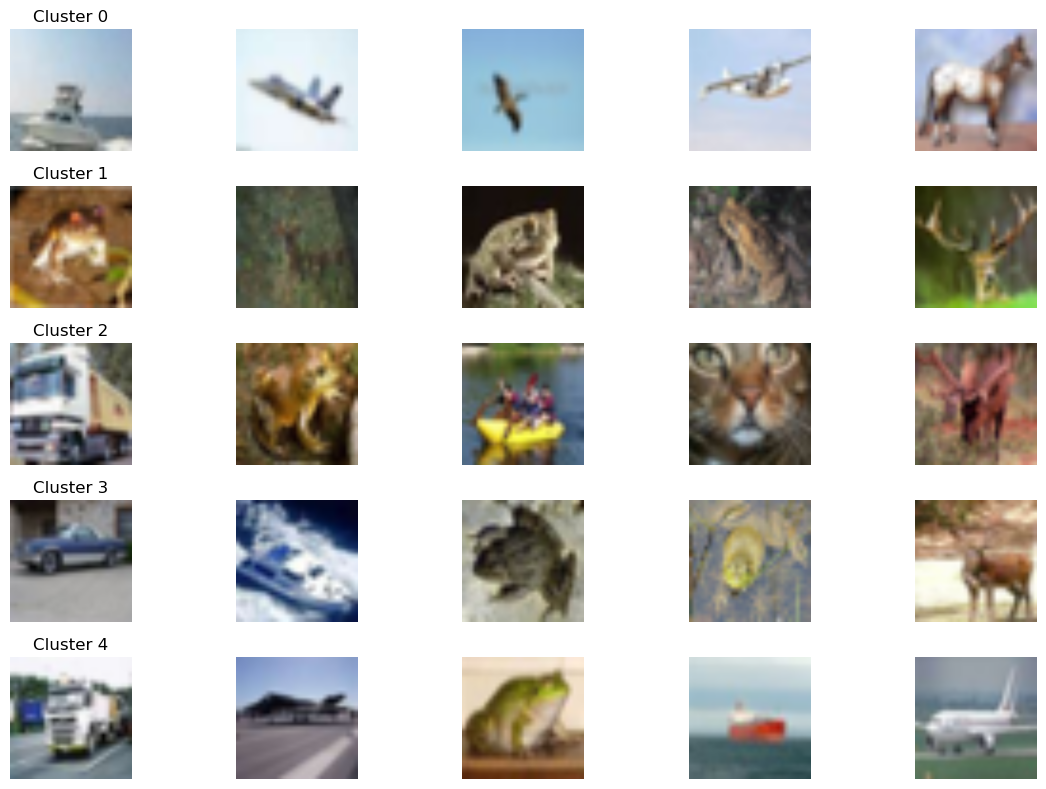

In [46]:
plot_clusters(clusters, image_folder)


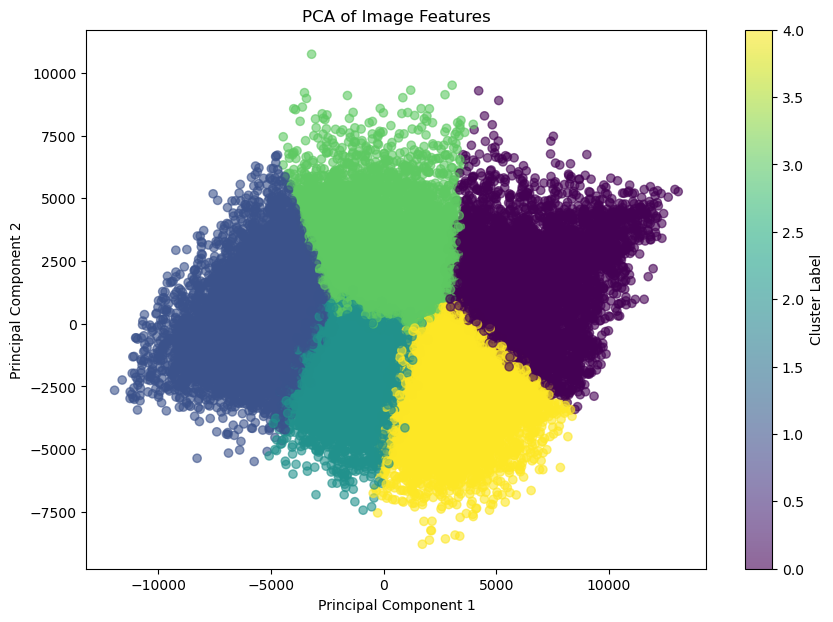

In [47]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

def plot_pca(features, labels, num_clusters):
    # Reduce the dimensionality of the features
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(features)
    
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Cluster Label')
    plt.title('PCA of Image Features')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Assuming features and labels are defined
plot_pca(features, labels, num_clusters)


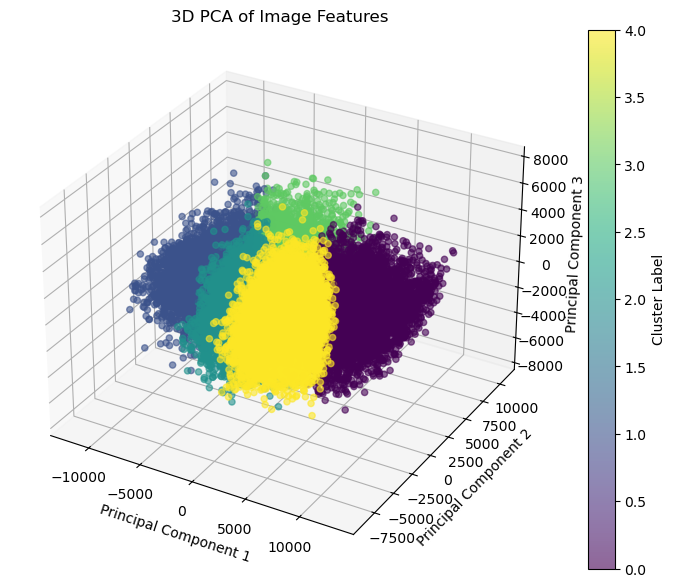

In [48]:
from mpl_toolkits.mplot3d import Axes3D

def plot_pca_3d(features, labels, num_clusters):
    # Reduce the dimensionality of the features
    pca = PCA(n_components=3)
    pca_features = pca.fit_transform(features)
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pca_features[:, 0], pca_features[:, 1], pca_features[:, 2], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Cluster Label')
    ax.set_title('3D PCA of Image Features')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    plt.show()

# Assuming features and labels are defined
plot_pca_3d(features, labels, num_clusters)
